# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn import model_selection
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [2]:
df = pd.read_csv("age_of_mariage.csv")
df.sample(n=10)

,id,gender,height,religion,caste,mother_tongue,profession,location,country,age_of_marriage
1116,1117,male,"6'0""",Hindu,Brahmin,Telugu,Admin Professional,Secunderabad,India,30.0
1274,1275,male,"5'9""",NaN,others,Malayalam,NaN,Kochi,India,28.0
1063,1064,male,"5'9""",NaN,others,Hindi,NaN,NaN,India,35.0
733,734,male,"5'11""",NaN,others,NaN,NaN,Chennai,India,27.0
2505,2506,female,"5'6""",Hindu,Brahmin,Bhojpuri,Not working,Siwan,India,31.0
1984,1985,male,"5'8""",Hindu,Brahmin,Hindi,Doctor / Healthcare Professional,Delhi,India,30.0
2436,2437,female,"5'5""",Hindu,Kshatriya,Hindi,Not working,Kolkata,India,31.0
1904,1905,male,"5'7""",Hindu,Brahmin,Bengali,Defense Services,Darjeeling,India,32.0
720,721,male,"5'8""",Jain,Shwetamber,Gujarati,Consultant / Supervisor / Team Leads,Bengaluru / Bangalore,India,33.0
360,361,male,"5'7""",Hindu,Bhandari,Konkani,Electronics / Telecom Engineer,Goa,India,30.0


In [3]:
df.shape

(2567, 10)

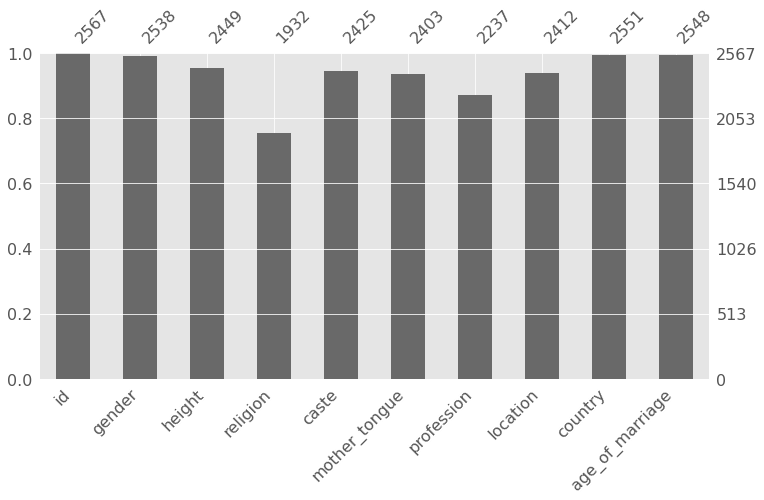

In [4]:
msno.bar(df, figsize=(12,6))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2567 entries, 0 to 2566
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2567 non-null   int64  
 1   gender           2538 non-null   object 
 2   height           2449 non-null   object 
 3   religion         1932 non-null   object 
 4   caste            2425 non-null   object 
 5   mother_tongue    2403 non-null   object 
 6   profession       2237 non-null   object 
 7   location         2412 non-null   object 
 8   country          2551 non-null   object 
 9   age_of_marriage  2548 non-null   float64
dtypes: float64(1), int64(1), object(8)
memory usage: 200.7+ KB


In [6]:
df.astype('object').describe().T

,count,unique,top,freq
id,2567,2567,1,1
gender,2538,2,male,1338
height,2449,28,"5'3""",229
religion,1932,5,Hindu,1576
caste,2425,42,others,493
mother_tongue,2403,27,Hindi,508
profession,2237,86,Not Specified,264
location,2412,536,Mumbai,213
country,2551,29,India,2246
age_of_marriage,2548.0,17.0,30.0,415.0


In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum().mul(100).div(len(df))

id                  0.000000
gender              1.129723
height              4.596806
religion           24.737047
caste               5.531749
mother_tongue       6.388781
profession         12.855473
location            6.038177
country             0.623296
age_of_marriage     0.740164
dtype: float64

In [9]:
df['height'][~df['height'].isna()] = (
    df['height'][~df['height'].isna()].str.replace('"', "")
    .str.split("'").apply(
        lambda x: int(x[0])*30.48 + int(x[1])*2.54
    )
)

In [10]:
df.head()

,id,gender,height,religion,caste,mother_tongue,profession,location,country,age_of_marriage
0,1,female,162.56,NaN,others,Telugu,NaN,London,United Kingdom,21.0
1,2,male,170.18,Jain,Shwetamber,Gujarati,Doctor / Healthcare Professional,Fairfax- VA,USA,32.0
2,3,male,170.18,Hindu,Brahmin,Hindi,Entrepreneurs / Business,Begusarai,India,32.0
3,4,female,152.4,Hindu,Thakur,Hindi,Architect,Mumbai,India,30.0
4,5,male,165.1,Christian,Born Again,Malayalam,Sales Professional / Marketing,Sulthan Bathery,India,30.0


In [11]:
df.isna().sum()

id                   0
gender              29
height             118
religion           635
caste              142
mother_tongue      164
profession         330
location           155
country             16
age_of_marriage     19
dtype: int64